### jet_estimate_normal
- for each point, find k nearest neighbors
- fit a polynomial surface (by least squares)
- estimate the local normal from gradient of fitted (local,smooth) polynomial

### jet_smooth_point_set
- for each point, find k nearest neighbors
- fit a polynomial surface (by least squares)
- project each point onto the (local,smooth) polynomial surface

this is quite similar to using PCA for smoothing point cloud except there, the local approximation was obtained by the eigenvectors of the covariance matrix

give a set of k-neighborhood points $\{ \vec{p}_i = (x_i,y_i,z_i)\}$ where $0 \leq i \leq k$ find a function $f(x,y,z)$ that is quadratic in $x,y,z$ i.e  
$$ f(x,y,z) = a_1x + a_2y + a_3z + a_4x^2 + a_5xy + a_6xz + a_7y^2 + ... = 0 $$ 
- This function $f(x,y,z)$ is the _level set_ of our points
- the best fit function $f(x,y,z)$ is obtained by minimizing $\Vert \mathbf{X} \vec{a} \Vert$ where the $i^{th}$ row of $\mathbf{X}$ is just $[x_i, y_i, z_i, x_i^2, x_iy_i, ... z_i^2]$ and $\vec{a} = [a_1, a_2, a_3, ... a_9]$ . $\vec{a}$ is normalized to have unit magnitude to avoid the trivial solution for the minimization problem
- the smallest singular vector of $\mathbf{X}$ gives the coefficients of $f$.
- In PCA we would have been interested in eigenvectors of the covariance matrix. Here we're interested in null-vectors $\mathbf{X}\vec{v} = 0$
- Then the gradient at the origin (the point of interest) is just $\vec{g} = [a_1,a_2,a_3]$ and the normal direction is the normalized $\vec{g}$.




### jet_smoothing algorithm
- translate the point+neighborhoods so that the point is at origin (much like the PCA version)
- find a quadratic function $z = f(x,y) = ax + by + cx^2 + dxy + ey^2$
- the surface normal at the origin is $\hat{n} = (-df/dx, -df/dy, -1)$
- the projection of the central point onto the fitted surface is $\vec{p}' = (0,0,f(0,0)) = (0,0,0)$ but for all other points (neighborhood points) we could use newton iteraiton to project the neighborhood points $\vec{p}' = \vec{p} - f(\vec{p}) / (|\vec{\nabla} f|^2) . \vec{\nabla} f$

In [66]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [67]:

def fit_local_surface(points):
    X = points[:, 0]
    Y = points[:, 1]
    Z = points[:, 2]
    A = np.column_stack([np.ones_like(X), X, Y, X**2, X*Y, Y**2])
    coeffs, _, _, _ = np.linalg.lstsq(A, Z, rcond=None)
    return coeffs


In [68]:

def project_to_surface(point,coeffs):
    # project a point onto z = f(x,y) = 0 using Newton iteration

    x,y,z = point
    for i in range(3): # do 3 iterations of newton method
        f = coeffs[0] + coeffs[1]*x + coeffs[2]*y + coeffs[3]*x**2 + coeffs[4]*x*y + coeffs[5]*y**2
        fx = coeffs[1] + 2*coeffs[3]*x + coeffs[4]*y
        fy = coeffs[2] + coeffs[4]*x + 2*coeffs[5]*y
        f_val = z - f
        grad = np.array([-fx, -fy, 1.0])
        z -= f_val / (grad @ grad)
    return np.array([x, y, z])

In [69]:
def jet_smooth_point_set(points,k=20):
    smoothed = points.copy()
    nn = NearestNeighbors(n_neighbors=k+1).fit(points)

    N = len(points)
    new_points = []
    for i in range(N):
        _,idx = nn.kneighbors(points[i:i+1])
        neighbors = points[idx[0][1:]]
        # local coords
        centered = neighbors - points[i]
        coeffs = fit_local_surface(centered)
        local_p = np.zeros(3)
        proj_local = project_to_surface(local_p,coeffs)
        new_p = proj_local + points[i]
        new_points.append(new_p)
    smoothed = np.array(new_points)
    points = smoothed.copy()
    nn.fit(smoothed)
    return smoothed
    
        

In [71]:
# Create noisy paraboloid data
np.random.seed(1)
n = 1000
x = np.random.uniform(-1, 1, n)
y = np.random.uniform(-1, 1, n)
z = x**2 + y**2 + 0.05*np.random.randn(n)
points = np.column_stack((x, y, z))

# Apply smoothing
smoothed = jet_smooth_point_set(points, k=30,)

print("Original mean z:", points[:,2].mean())
print("Smoothed mean z:", smoothed[:,2].mean())


Original mean z: 0.6767916621671984
Smoothed mean z: 0.6760814247738874


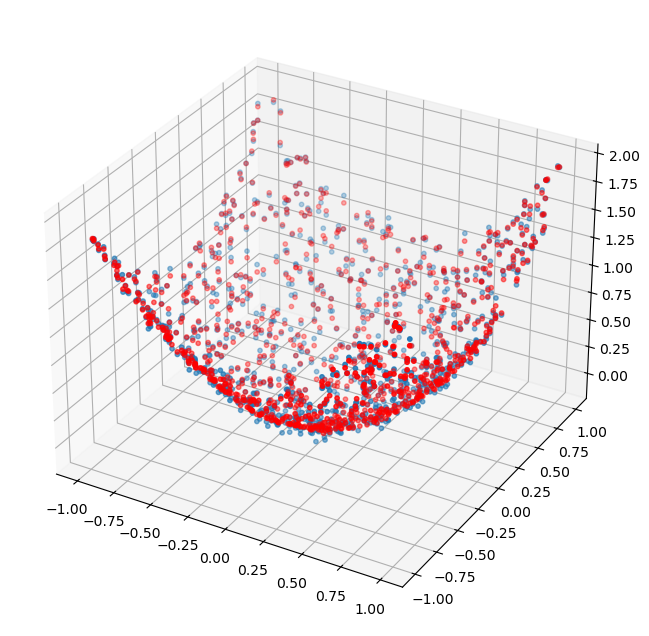

In [72]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=10)
ax.scatter(smoothed[:,0], smoothed[:,1], smoothed[:,2], s=10,color='red')
plt.show()
